# Notebook Setup

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

In [1]:
# Import Libraries

# TensorFlow
import tensorflow as tf
from tensorflow import keras

# Maths
import numpy as np
import matplotlib.pyplot as plt

# Gym
import gym

# Virtual Display
# import pyvirtualdisplay

# Common
import os
import sys

# Other
from collections import deque

C:\Users\Cael Milne\AppData\Local\Programs\Python\Python37\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
# Global Variables
PROJECT_ROOT_DIR = 'drive/MyDrive/ML/Keras_Version'

# SEEDS
np.random.seed(69)
tf.random.set_seed(420)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Helper Functions

In [ ]:
# Pre-Processing
def preprocess_observation(observation):

    # Slice Top Off
    img = observation[14:210:2, ::2]

    # Grey Scale
    img = img.mean(axis=2)
    img = (img - 128).astype(np.float32)

    return img.reshape(98, 80, 1)

In [3]:
# Epsilon Greedy Policy
def epsilon_greedy_policy(ram, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(np.array([ram]))
        return np.argmax(Q_values[0])

In [4]:
# Sample Experiences
def sample_experiences(batch_size):
    indices = np.random.randint(len(REPLAY_MEMORY), size=batch_size)
    batch = [REPLAY_MEMORY[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [5]:
# One Iteration
def playRAM(env, ram, epsilon, frame_skip):

    # Get Action
    action = epsilon_greedy_policy(ram, epsilon)

    # Do Action frame_skip Times
    iter_reward = 0
    for frame in range(frame_skip):
        next_state, reward, done, info = env.step(action)
        iter_reward += reward

    next_state = env.ale.getRAM()

    # Add Last Frame to Buffer
    REPLAY_MEMORY.append((ram, action, iter_reward, next_state, done))
    return next_state, iter_reward, done, info

In [6]:
# Config
batch_size = 32
discount_rate = 0.99
learning_rate = 0.00025
momentum = 0.95
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
loss_fn = keras.losses.mean_squared_error

# Train from Memory
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values).reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Q-Learning with Frames

In [7]:
# Create Environment
keras.backend.clear_session()

env = gym.make("AssaultNoFrameskip-v4")
input_shape = (98, 80, 1)
n_outputs = env.action_space.n

initializer = keras.initializers.VarianceScaling()

# Create Model
model = keras.models.Sequential([
                               keras.layers.Dense(units=128, activation="relu", kernel_initializer=initializer),
                               keras.layers.Dense(n_outputs, activation="relu", kernel_initializer=initializer)
])

# model.summary()

In [8]:
# Train Convolutional Model

# CONFIG
env.seed(710)
REPLAY_MEMORY = deque(maxlen=100)
FRAMESKIP = 4
EPISODES = 1000
STEPS = 1000000
WARMUP = 35


episode_rewards = []
best_score = 0

step = 0
for episode in range(EPISODES):
    
    obs = env.reset()
    ram = env.ale.getRAM()
    
    episode_rewards.append(0)
    while True:
        step += 1
        epsilon = max(1 - episode / EPISODES, 0.01)

        ram, reward, done, info = playRAM(env, ram, epsilon, FRAMESKIP)

        episode_rewards[episode] += reward

        if done:
            break

    print("\rEpisode: {}, Steps: {}, eps: {:.3f}, current_reward: {}".format(episode, step + 1, epsilon, episode_rewards[episode]), end="")
    
    # if episode > WARMUP:
    training_step(batch_size)

np.savetxt(PROJECT_ROOT_DIR + "/RESULTS/" + "res.csv", np.asarray(episode_rewards), delimiter=",")

Episode: 98, Steps: 57216, eps: 0.902, current_reward: 315.0

KeyboardInterrupt: 

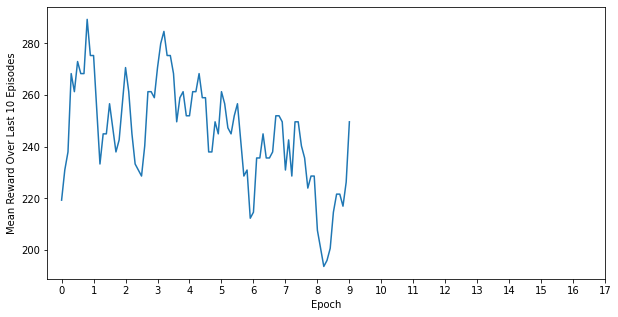

In [9]:
# Plot Results

EPISODES_PER_EPOCH = 9

average_rewards = [np.mean(episode_rewards[i - EPISODES_PER_EPOCH : i]) for i in range(len(episode_rewards), EPISODES_PER_EPOCH, -1)]

bins = [x/10 for x in range(len(average_rewards))] 
plt.figure(figsize=(10, 5))
plt.plot(bins, average_rewards)

plt.xticks(list(range(0, 18)))
plt.xlabel("Epoch")
plt.ylabel("Mean Reward Over Last 10 Episodes")
plt.show()